In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pm = pd.read_excel('PM.xlsx')
pm = pm.rename(columns={'Unnamed: 0':'Time'})
pm /= 100
pm.head()

,Time,PM1,PM2
0,2005.01,-0.063230,0.006049
1,2005.02,0.005775,0.023234
2,2005.03,-0.040356,-0.011162
3,2005.04,-0.062735,-0.019199
4,2005.05,0.077903,0.037375


In [3]:
data = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=3, nrows=1134)
data = data.rename(columns={'Unnamed: 0':'Time'})
data /= 100
data.head()

,Time,Mkt-RF,SMB,HML,RF
0,1926.07,0.0296,-0.0230,-0.0287,0.0022
1,1926.08,0.0264,-0.0140,0.0419,0.0025
2,1926.09,0.0036,-0.0132,0.0001,0.0023
3,1926.10,-0.0324,0.0004,0.0051,0.0032
4,1926.11,0.0253,-0.0020,-0.0035,0.0031


## (a) Summarize the performances of the two managers

In [4]:
pm = pd.merge(pm, data, on='Time', how='left')
pm

,Time,PM1,PM2,Mkt-RF,SMB,HML,RF
0,2005.01,-0.063230,0.006049,-0.0276,-0.0172,0.0201,0.0016
1,2005.02,0.005775,0.023234,0.0189,-0.0055,0.0163,0.0016
2,2005.03,-0.040356,-0.011162,-0.0197,-0.0135,0.0214,0.0021
3,2005.04,-0.062735,-0.019199,-0.0261,-0.0397,0.0005,0.0021
4,2005.05,0.077903,0.037375,0.0365,0.0280,-0.0066,0.0024
5,2005.06,0.005936,0.008399,0.0057,0.0255,0.0282,0.0023
6,2005.07,0.080005,0.042041,0.0392,0.0287,-0.0083,0.0024
7,2005.08,-0.030622,-0.007527,-0.0122,-0.0098,0.0138,0.0030
8,2005.09,0.001882,0.028556,0.0049,-0.0066,0.0074,0.0029
9,2005.10,-0.046892,-0.008249,-0.0202,-0.0119,0.0045,0.0027


In [5]:
Time = pd.to_datetime(pm.Time*100, format='%Y%m', errors='coerce')
pm['PM1-RF'] = pm.PM1 - pm.RF
pm['PM2-RF'] = pm.PM2 - pm.RF
pm.head()

,Time,PM1,PM2,Mkt-RF,SMB,HML,RF,PM1-RF,PM2-RF
0,2005.01,-0.063230,0.006049,-0.0276,-0.0172,0.0201,0.0016,-0.064830,0.004449
1,2005.02,0.005775,0.023234,0.0189,-0.0055,0.0163,0.0016,0.004175,0.021634
2,2005.03,-0.040356,-0.011162,-0.0197,-0.0135,0.0214,0.0021,-0.042456,-0.013262
3,2005.04,-0.062735,-0.019199,-0.0261,-0.0397,0.0005,0.0021,-0.064835,-0.021299
4,2005.05,0.077903,0.037375,0.0365,0.0280,-0.0066,0.0024,0.075503,0.034975


#### Scatter plot

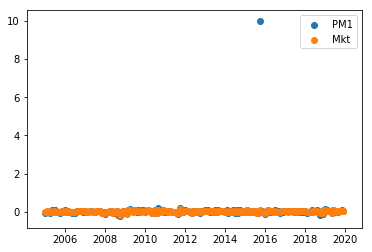

In [8]:
plt.scatter(Time,pm['PM1-RF'],label='PM1')
plt.scatter(Time,pm['Mkt-RF'],label='Mkt')
plt.legend()

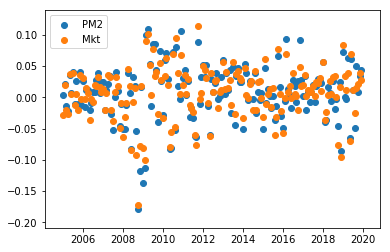

In [7]:
plt.scatter(Time,pm['PM2-RF'],label='PM2')
plt.scatter(Time,pm['Mkt-RF'],label='Mkt')
plt.legend()

#### Boxplot

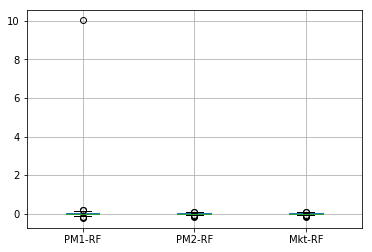

In [9]:
pm.boxplot(column=['PM1-RF','PM2-RF','Mkt-RF'])

#### treat outliers

In [10]:
pm_ = pm.drop(pm.index[pm.PM1 ==max(pm.PM1)])
#(pm['PM1-RF'].sum()-max(pm['PM1-RF']))/(len(pm)-1)

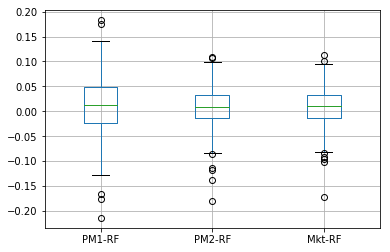

In [11]:
pm_.boxplot(column=['PM1-RF','PM2-RF','Mkt-RF'])

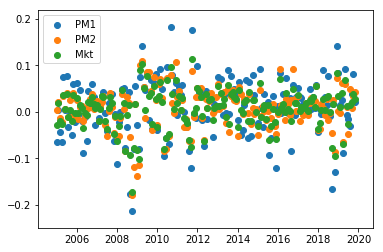

In [14]:
plt.scatter(Time[:-1],pm_['PM1-RF'],label='PM1')
plt.scatter(Time[:-1],pm_['PM2-RF'],label='PM2')
plt.scatter(Time[:-1],pm_['Mkt-RF'],label='Mkt')
plt.legend()

In [15]:
def analyze(monthly_ret,excess_ret):
    mean = np.mean(monthly_ret)
    std = np.std(monthly_ret)
    SR = np.mean(excess_ret)*12 / (np.std(excess_ret)*12**0.5)
    diff = excess_ret - pm['Mkt-RF']
    info = np.mean(diff)*12 / (np.std(diff)*12**0.5)
    val = np.asarray((1+monthly_ret).cumprod())
    index_j = np.argmax(np.maximum.accumulate(val) - val) # min
    index_i = np.argmax(val[:index_j]) # max
    drawdown = 1 - val[index_j]/val[index_i]
   
    result = pd.DataFrame({'Monthly Return':[mean],\
                           'Monthly Standard Deviation':[std],\
                           'Annual Sharpe Ratio':[SR], \
                           'Annual Information Ratio': [info],\
                           'Max Drowdown': [drawdown]})
    return result

In [16]:
summary = analyze(pm_.PM1,pm_['PM1-RF']).append(analyze(pm.PM2,pm['PM2-RF']))
summary.index = ['PM1','PM2']
summary

,Monthly Return,Monthly Standard Deviation,Annual Sharpe Ratio,Annual Information Ratio,Max Drowdown
PM1,0.010818,0.060379,0.558556,0.364041,0.262289
PM2,0.008184,0.044262,0.557011,-0.006225,0.544678


## (b)  Outperform the market? Alpha?

In [18]:
import statsmodels.formula.api as smf
pm_ = pm_.rename(columns={'PM1-RF':'PM1_RF'})
pm_ = pm_.rename(columns={'PM2-RF':'PM2_RF'})
pm_ = pm_.rename(columns={'Mkt-RF':'Mkt_RF'})
est1 = smf.ols(formula='PM1_RF ~ Mkt_RF + SMB + HML', data=pm_).fit()
est1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PM1_RF   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     6075.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          1.32e-176
Time:                        14:19:00   Log-Likelihood:                 664.75
No. Observations:                 179   AIC:                            -1322.
Df Residuals:                     175   BIC:                            -1309.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.027e-05      0.000     -0.199      0.843      -0.001       0.001
Mkt_RF         1.2939      0.012    107.017      0.000       1.270       1.318
SMB            0.8033      0.021     37.874      0.000       0.761       0.845
HML           -0.6884      0.018    -38.214      0.000      -0.724      -0.653
==============================================================================
Omnibus:                        0.140   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.932   Jarque-Bera (JB):                0.128
Skew:                          -0.062   Prob(JB):                        0.938
Kurtosis:                       2.957   Cond. No.                         48.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
pm = pm.rename(columns={'PM1-RF':'PM1_RF'})
pm = pm.rename(columns={'PM2-RF':'PM2_RF'})
pm = pm.rename(columns={'Mkt-RF':'Mkt_RF'})
est2 = smf.ols(formula='PM2_RF ~ Mkt_RF + SMB + HML', data=pm).fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PM2_RF   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1441.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          1.37e-123
Time:                        14:19:07   Log-Likelihood:                 597.24
No. Observations:                 180   AIC:                            -1186.
Df Residuals:                     176   BIC:                            -1174.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.001      1.488      0.138      -0.000       0.002
Mkt_RF         0.9512      0.018     53.719      0.000       0.916       0.986
SMB           -0.1176      0.031     -3.761      0.000      -0.179      -0.056
HML            0.5336      0.027     19.951      0.000       0.481       0.586
==============================================================================
Omnibus:                        0.120   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.942   Jarque-Bera (JB):                0.023
Skew:                           0.025   Prob(JB):                        0.989
Kurtosis:                       3.023   Cond. No.                         48.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##  (c) Statistical tests

### Beating the market

In [20]:
pm_['PM1_Mkt'] = pm_['PM1_RF'] - pm_['Mkt_RF']
pm_['PM2_Mkt'] = pm_['PM2_RF'] - pm_['Mkt_RF']
pm_.head()

,Time,PM1,PM2,Mkt_RF,SMB,HML,RF,PM1_RF,PM2_RF,PM1_Mkt,PM2_Mkt
0,2005.01,-0.063230,0.006049,-0.0276,-0.0172,0.0201,0.0016,-0.064830,0.004449,-0.037230,0.032049
1,2005.02,0.005775,0.023234,0.0189,-0.0055,0.0163,0.0016,0.004175,0.021634,-0.014725,0.002734
2,2005.03,-0.040356,-0.011162,-0.0197,-0.0135,0.0214,0.0021,-0.042456,-0.013262,-0.022756,0.006438
3,2005.04,-0.062735,-0.019199,-0.0261,-0.0397,0.0005,0.0021,-0.064835,-0.021299,-0.038735,0.004801
4,2005.05,0.077903,0.037375,0.0365,0.0280,-0.0066,0.0024,0.075503,0.034975,0.039003,-0.001525


In [21]:
from scipy import stats
stats.ttest_ind(pm_['PM1_Mkt'], pm_['PM2_Mkt'])

Ttest_indResult(statistic=1.207392065004469, pvalue=0.22808275619817422)

In [22]:
from scipy import stats
stats.ttest_ind(pm_['PM1_Mkt']>0, pm_['PM2_Mkt']>0)

Ttest_indResult(statistic=1.8010871004332931, pvalue=0.07253527953205546)

### Sharpe ratio

In [23]:
x1 = pm_['PM1_RF']
x2 = pm_['PM2_RF']
mu1 = x1.mean()*12
mu2 = x2.mean()*12
sigma1 = x1.std()*12**0.5
sigma2 = x2.std()*12**0.5

In [24]:
A = np.array([1/sigma1, -mu1/sigma1**2, -1/sigma2, mu2/sigma2**2])
A

array([ 4.75770867, -2.6500112 , -6.50820887,  3.45611472])

In [25]:
d = -1*np.identity(4)
d[1,1] = -2*sigma1
d[3,3] = -2*sigma2
d

array([[-1.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.42037042, -0.        , -0.        ],
       [-0.        , -0.        , -1.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.30730421]])

In [26]:
f1 = x1 - mu1
f2 = (x1 - mu1)**2 - sigma1**2
f3 = x2 - mu2
f4 = (x2 - mu2)**2 - sigma2**2
f = np.array([f1,f2,f3,f4])
S = np.dot(f,f.T)
S

array([[2.71678827, 0.39646824, 1.7975358 , 0.2433801 ],
       [0.39646824, 0.19692863, 0.29838624, 0.10189059],
       [1.7975358 , 0.29838624, 1.3515967 , 0.15152749],
       [0.2433801 , 0.10189059, 0.15152749, 0.05992835]])

In [27]:
V = np.linalg.inv(d@np.linalg.inv(S)@d.T)/pm_.shape[0]
V

array([[0.01517759, 0.00526894, 0.0100421 , 0.00442449],
       [0.00526894, 0.00622575, 0.00396546, 0.00440636],
       [0.0100421 , 0.00396546, 0.00755082, 0.00275467],
       [0.00442449, 0.00440636, 0.00275467, 0.00354521]])

In [28]:
var_h = A@V@A.T
var_h

0.07235359243574153

In [29]:
h = mu1/sigma1 - mu2/sigma2
tval = h/var_h**0.5
tval

0.09648767956142054

In [30]:
pval = stats.t.sf(np.abs(tval), pm_.shape[0]-1)*2
pval

0.9232418075212461

### Information ratio

In [31]:
y1 = pm_['PM1_RF'] - est1.predict(pm_[['Mkt_RF','SMB','HML']])
y2 = pm_['PM2_RF'] - est2.predict(pm_[['Mkt_RF','SMB','HML']])
alpha1 = y1.mean()*12
alpha2 = y2.mean()*12
eps1 = y1.std()*12**0.5
eps2 = y2.std()*12**0.5

In [32]:
A = np.array([1/eps1, -alpha1/eps1**2, -1/eps2, alpha2/eps2**2])
A

array([ 4.87836784e+01,  2.96136089e-14, -3.28668769e+01,  7.18426823e-01])

In [33]:
d = -1*np.identity(4)
d[1,1] = -2*eps1
d[3,3] = -2*eps2
d

array([[-1.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.04099732, -0.        , -0.        ],
       [-0.        , -0.        , -1.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.06085154]])

In [34]:
f1 = y1 - alpha1
f2 = (y1 - alpha1)**2 - eps1**2
f3 = y2 - alpha2
f4 = (y2 - alpha2)**2 - eps2**2
f = np.array([f1,f2,f3,f4])
S = np.dot(f,f.T)
S

array([[ 6.23289295e-03, -2.28144983e-06, -5.21007645e-04,
         1.08059077e-06],
       [-2.28144983e-06,  2.70087357e-05,  4.26569988e-05,
         5.85031685e-05],
       [-5.21007645e-04,  4.26569988e-05,  1.37981517e-02,
         7.76055581e-05],
       [ 1.08059077e-06,  5.85031685e-05,  7.76055581e-05,
         1.31079539e-04]])

In [35]:
V = np.linalg.inv(d@np.linalg.inv(S)@d.T)/pm_.shape[0]
V

array([[ 3.48206310e-05, -3.10886913e-07, -2.91065724e-06,
         9.92057092e-08],
       [-3.10886913e-07,  8.97718803e-05,  5.81275227e-06,
         1.31008462e-04],
       [-2.91065724e-06,  5.81275227e-06,  7.70846464e-05,
         7.12472716e-06],
       [ 9.92057092e-08,  1.31008462e-04,  7.12472716e-06,
         1.97760139e-04]])

In [36]:
var_h = A@V@A.T
var_h

0.17524331969842566

In [37]:
h = alpha1/eps1 - alpha2/eps2
tval = h/var_h**0.5
tval

-0.05221597176624682

In [38]:
pval = stats.t.sf(np.abs(tval), pm_.shape[0]-1)*2
pval

0.9584151592527077